# Model trained on dataset B1 

In [31]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import copy

### Data loading

In [32]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255   
        image = image[:,:,:3] 
        class_label = self.img_annotations.iloc[idx,2]-1     
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label
    
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize]) 

train = PetDataset('annotations_aug/annotations_train_B1.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid_B1.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test_B1.csv','img_augmented_processed/', transform = trans)

train_loader = DataLoader(train,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


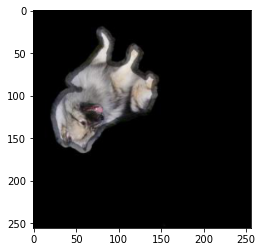

In [33]:
train_b1_img, train_b1_label = next(iter(train_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

### Model

In [34]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( #nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( #nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model = PetCNN6()
loss_function = nn.NLLLoss()

#print(model)

### Helper functions

In [35]:
def model_dict(model,iteration,current_train_accuracy,current_valid_accuracy):
    """
    Returns a dictionary with a deep copy of the model in its current state and the associated accuracy metrics.
    """
    
    return {'current_model': copy.deepcopy(model), 'current_iter':copy.deepcopy(iteration), 'current_train_acc':copy.deepcopy(current_train_accuracy), 'current_valid_acc':copy.deepcopy(current_valid_accuracy)}

def add_to_saved_models(saved_models,length,model,iteration,current_train_accuracy,current_valid_accuracy):
    """
    saved_models is a list of specified length where we save the deep copies of the model at different training stages with the best validation accuracies.
    
    This function adds a dictionary created by model_dict(...) defined above either if the list of saved_models is not full yet, or if the current version of the model is better than the worst one already saved in the list.
    """
    
    dic = model_dict(model,iteration,current_train_accuracy,current_valid_accuracy)
    
    if len(saved_models)<length:
        saved_models.append(dic)
    else:
        valid_acc_list = [dictionary[current_valid_acc] for dictionary in saved_models]
        min_valid_acc = min(valid_acc_list)
        min_valid_index = valid_acc_list.index(min_valid_acc)
        
        if dic[current_valid_acc] > min_valid_acc:
            saved_models[min_valid_index] = dic

### Training

In [36]:
saved_models = []

learning_rate = 0.001
wt_decay = 0.0003
lr_decay = 0.75    # we'll go for a learning rate decay by a factor of 0.75 every 2 epochs

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=wt_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=lr_decay)

num_epochs = 50

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()


for epoch in range(num_epochs):
    for images, labels in train_loader:
        model.train()
        out = model(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%25==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 25 iterations: {}'.format(end-start))
            print('Current learning rate:{}'.format(optimizer.param_groups[0]['lr']))    # to print the current learning rate that is decaying every 2 epochs
            
            
            if epoch>0:      # after the first epoch, every 25th iteration is a checkpoint
                
                model.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=1024,shuffle=True)   # a (pseudo) random batch from the training set
                    images_c, labels_c = next(iter(train_part))
                    train_out = model(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/1024
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)
                    
                    if current_valid_accuracy > 0.53:
                        add_to_saved_models(saved_models,5,model,iteration,current_train_accuracy,current_valid_accuracy)
                        

                
            start = time.time()
            
    scheduler.step()
                


Epoch:0
Iteration:25
Time taken for the last 25 iterations: 35.69231629371643
Current learning rate:0.001
Epoch:0
Iteration:50
Time taken for the last 25 iterations: 35.140674114227295
Current learning rate:0.001
Epoch:0
Iteration:75
Time taken for the last 25 iterations: 35.074955463409424
Current learning rate:0.001
Epoch:0
Iteration:100
Time taken for the last 25 iterations: 34.89954495429993
Current learning rate:0.001
Epoch:0
Iteration:125
Time taken for the last 25 iterations: 35.95368671417236
Current learning rate:0.001
Epoch:0
Iteration:150
Time taken for the last 25 iterations: 33.37712025642395
Current learning rate:0.001
Epoch:0
Iteration:175
Time taken for the last 25 iterations: 32.8279926776886
Current learning rate:0.001
Epoch:0
Iteration:200
Time taken for the last 25 iterations: 34.834521770477295
Current learning rate:0.001
Epoch:0
Iteration:225
Time taken for the last 25 iterations: 34.0968861579895
Current learning rate:0.001
Epoch:0
Iteration:250
Time taken for th

Epoch:3
Iteration:925
Time taken for the last 25 iterations: 27.877547025680542
Current learning rate:0.00075
Current training loss:2.4386935234069824
Current training accuracy:0.302734375
Current validation loss:2.3308181762695312
Current validation accuracy:0.34646373987197876
Epoch:3
Iteration:950
Time taken for the last 25 iterations: 28.550609350204468
Current learning rate:0.00075
Current training loss:2.3633806705474854
Current training accuracy:0.3427734375
Current validation loss:2.2909841537475586
Current validation accuracy:0.3786929249763489
Epoch:3
Iteration:975
Time taken for the last 25 iterations: 27.522778034210205
Current learning rate:0.00075
Current training loss:2.343026638031006
Current training accuracy:0.345703125
Current validation loss:2.353753089904785
Current validation accuracy:0.3509400188922882
Epoch:3
Iteration:1000
Time taken for the last 25 iterations: 28.737890005111694
Current learning rate:0.00075
Current training loss:2.4317212104797363
Current tra

Current training loss:1.857162594795227
Current training accuracy:0.509765625
Current validation loss:1.9925795793533325
Current validation accuracy:0.4341987371444702
Epoch:6
Iteration:1650
Time taken for the last 25 iterations: 30.154032468795776
Current learning rate:0.00042187500000000005
Current training loss:1.792172908782959
Current training accuracy:0.498046875
Current validation loss:1.9720505475997925
Current validation accuracy:0.4377797544002533
Epoch:6
Iteration:1675
Time taken for the last 25 iterations: 31.405362844467163
Current learning rate:0.00042187500000000005
Current training loss:1.843104600906372
Current training accuracy:0.50390625
Current validation loss:2.007453203201294
Current validation accuracy:0.42345568537712097
Epoch:6
Iteration:1700
Time taken for the last 25 iterations: 28.87526845932007
Current learning rate:0.00042187500000000005
Current training loss:1.7865171432495117
Current training accuracy:0.517578125
Current validation loss:1.970940709114074

Current training loss:1.475468397140503
Current training accuracy:0.599609375
Current validation loss:1.8518140316009521
Current validation accuracy:0.47806623578071594
Epoch:9
Iteration:2350
Time taken for the last 25 iterations: 28.49628210067749
Current learning rate:0.00031640625000000006
Current training loss:1.554025650024414
Current training accuracy:0.5703125
Current validation loss:1.9897301197052002
Current validation accuracy:0.42076992988586426
Epoch:9
Iteration:2375
Time taken for the last 25 iterations: 27.880436658859253
Current learning rate:0.00031640625000000006
Current training loss:1.583299994468689
Current training accuracy:0.56640625
Current validation loss:1.9729976654052734
Current validation accuracy:0.4252462089061737
Epoch:9
Iteration:2400
Time taken for the last 25 iterations: 28.514917373657227
Current learning rate:0.00031640625000000006
Current training loss:1.5448777675628662
Current training accuracy:0.57421875
Current validation loss:1.9446110725402832

Current training loss:1.0888981819152832
Current training accuracy:0.7421875
Current validation loss:1.773781180381775
Current validation accuracy:0.4843330383300781
Epoch:11
Iteration:3050
Time taken for the last 25 iterations: 29.12223792076111
Current learning rate:0.00023730468750000005
Current training loss:1.1560964584350586
Current training accuracy:0.712890625
Current validation loss:1.741581916809082
Current validation accuracy:0.493285596370697
Epoch:11
Iteration:3075
Time taken for the last 25 iterations: 29.69667148590088
Current learning rate:0.00023730468750000005
Current training loss:1.1230486631393433
Current training accuracy:0.73046875
Current validation loss:1.7564880847930908
Current validation accuracy:0.49597135186195374
Epoch:11
Iteration:3100
Time taken for the last 25 iterations: 26.138296365737915
Current learning rate:0.00023730468750000005
Current training loss:1.1070778369903564
Current training accuracy:0.7451171875
Current validation loss:1.7537846565246

Current training loss:1.014884352684021
Current training accuracy:0.7880859375
Current validation loss:1.7555019855499268
Current validation accuracy:0.4905998110771179
Epoch:14
Iteration:3750
Time taken for the last 25 iterations: 31.127946853637695
Current learning rate:0.00013348388671875002
Current training loss:0.9197864532470703
Current training accuracy:0.8056640625
Current validation loss:1.7471200227737427
Current validation accuracy:0.48701879382133484
Epoch:14
Iteration:3775
Time taken for the last 25 iterations: 29.009812116622925
Current learning rate:0.00013348388671875002
Current training loss:1.0123875141143799
Current training accuracy:0.765625
Current validation loss:1.7538198232650757
Current validation accuracy:0.4905998110771179
Epoch:14
Iteration:3800
Time taken for the last 25 iterations: 31.199465036392212
Current learning rate:0.00013348388671875002
Current training loss:0.9326596856117249
Current training accuracy:0.8046875
Current validation loss:1.7536916732

Current training loss:0.8217303156852722
Current training accuracy:0.8310546875
Current validation loss:1.7289233207702637
Current validation accuracy:0.506714403629303
Epoch:17
Iteration:4450
Time taken for the last 25 iterations: 27.699360609054565
Current learning rate:0.00010011291503906251
Current training loss:0.7715113162994385
Current training accuracy:0.84375
Current validation loss:1.734384298324585
Current validation accuracy:0.49865710735321045
Epoch:17
Iteration:4475
Time taken for the last 25 iterations: 28.847899675369263
Current learning rate:0.00010011291503906251
Current training loss:0.8608566522598267
Current training accuracy:0.8251953125
Current validation loss:1.7205928564071655
Current validation accuracy:0.49865710735321045
Epoch:17
Iteration:4500
Time taken for the last 25 iterations: 30.97067356109619
Current learning rate:0.00010011291503906251
Current training loss:0.775277316570282
Current training accuracy:0.83984375
Current validation loss:1.721256732940

Current training loss:0.7097460627555847
Current training accuracy:0.8779296875
Current validation loss:1.7215465307235718
Current validation accuracy:0.5004476308822632
Epoch:19
Iteration:5150
Time taken for the last 25 iterations: 31.935680866241455
Current learning rate:7.508468627929689e-05
Current training loss:0.6841989755630493
Current training accuracy:0.880859375
Current validation loss:1.73092520236969
Current validation accuracy:0.4968666136264801
Epoch:19
Iteration:5175
Time taken for the last 25 iterations: 30.39001774787903
Current learning rate:7.508468627929689e-05
Current training loss:0.7629040479660034
Current training accuracy:0.8525390625
Current validation loss:1.733712911605835
Current validation accuracy:0.5004476308822632
Epoch:19
Iteration:5200
Time taken for the last 25 iterations: 31.924471855163574
Current learning rate:7.508468627929689e-05
Current training loss:0.7023018002510071
Current training accuracy:0.8681640625
Current validation loss:1.72491705417

Current training loss:0.6023198366165161
Current training accuracy:0.9052734375
Current validation loss:1.7352179288864136
Current validation accuracy:0.49597135186195374
Epoch:22
Iteration:5850
Time taken for the last 25 iterations: 27.757920742034912
Current learning rate:4.22351360321045e-05
Current training loss:0.6720768213272095
Current training accuracy:0.8662109375
Current validation loss:1.7330067157745361
Current validation accuracy:0.49597135186195374
Epoch:22
Iteration:5875
Time taken for the last 25 iterations: 28.88083267211914
Current learning rate:4.22351360321045e-05
Current training loss:0.6630070805549622
Current training accuracy:0.8720703125
Current validation loss:1.7275805473327637
Current validation accuracy:0.5004476308822632
Epoch:22
Iteration:5900
Time taken for the last 25 iterations: 28.955740928649902
Current learning rate:4.22351360321045e-05
Current training loss:0.6191885471343994
Current training accuracy:0.9033203125
Current validation loss:1.73340570

Current training loss:0.5899012088775635
Current training accuracy:0.8974609375
Current validation loss:1.7547433376312256
Current validation accuracy:0.4968666136264801
Epoch:25
Iteration:6550
Time taken for the last 25 iterations: 27.61781334877014
Current learning rate:3.167635202407837e-05
Current training loss:0.6501438021659851
Current training accuracy:0.8779296875
Current validation loss:1.7539962530136108
Current validation accuracy:0.4995523691177368
Epoch:25
Iteration:6575
Time taken for the last 25 iterations: 29.954862117767334
Current learning rate:3.167635202407837e-05
Current training loss:0.6245625615119934
Current training accuracy:0.8994140625
Current validation loss:1.7445627450942993
Current validation accuracy:0.5031334161758423
Epoch:25
Iteration:6600
Time taken for the last 25 iterations: 29.324207544326782
Current learning rate:3.167635202407837e-05
Current training loss:0.6429575681686401
Current training accuracy:0.896484375
Current validation loss:1.73434400

Current training loss:0.5751144289970398
Current training accuracy:0.9091796875
Current validation loss:1.7439484596252441
Current validation accuracy:0.49507609009742737
Epoch:27
Iteration:7250
Time taken for the last 25 iterations: 30.74088144302368
Current learning rate:2.3757264018058778e-05
Current training loss:0.5583630800247192
Current training accuracy:0.9140625
Current validation loss:1.7363662719726562
Current validation accuracy:0.49865710735321045
Epoch:27
Iteration:7275
Time taken for the last 25 iterations: 30.26844573020935
Current learning rate:2.3757264018058778e-05
Current training loss:0.6047003865242004
Current training accuracy:0.9013671875
Current validation loss:1.7453793287277222
Current validation accuracy:0.4968666136264801
Epoch:27
Iteration:7300
Time taken for the last 25 iterations: 28.803090572357178
Current learning rate:2.3757264018058778e-05
Current training loss:0.6070459485054016
Current training accuracy:0.900390625
Current validation loss:1.7435299

Current training loss:0.5843788385391235
Current training accuracy:0.9072265625
Current validation loss:1.7418609857559204
Current validation accuracy:0.4914950728416443
Epoch:30
Iteration:7950
Time taken for the last 25 iterations: 31.118053674697876
Current learning rate:1.3363461010158061e-05
Current training loss:0.5581942796707153
Current training accuracy:0.908203125
Current validation loss:1.743314266204834
Current validation accuracy:0.49507609009742737
Epoch:30
Iteration:7975
Time taken for the last 25 iterations: 27.383670806884766
Current learning rate:1.3363461010158061e-05
Current training loss:0.5398648977279663
Current training accuracy:0.9150390625
Current validation loss:1.7437748908996582
Current validation accuracy:0.493285596370697
Epoch:30
Iteration:8000
Time taken for the last 25 iterations: 25.492398023605347
Current learning rate:1.3363461010158061e-05
Current training loss:0.5410478711128235
Current training accuracy:0.9150390625
Current validation loss:1.74444

Current training loss:0.5668503642082214
Current training accuracy:0.91015625
Current validation loss:1.7523713111877441
Current validation accuracy:0.4914950728416443
Epoch:33
Iteration:8650
Time taken for the last 25 iterations: 28.437857627868652
Current learning rate:1.0022595757618546e-05
Current training loss:0.5538641214370728
Current training accuracy:0.9130859375
Current validation loss:1.74399733543396
Current validation accuracy:0.49507609009742737
Epoch:33
Iteration:8675
Time taken for the last 25 iterations: 28.953777074813843
Current learning rate:1.0022595757618546e-05
Current training loss:0.572607159614563
Current training accuracy:0.9111328125
Current validation loss:1.7474596500396729
Current validation accuracy:0.4914950728416443
Epoch:33
Iteration:8700
Time taken for the last 25 iterations: 28.777133464813232
Current learning rate:1.0022595757618546e-05
Current training loss:0.5334516167640686
Current training accuracy:0.9189453125
Current validation loss:1.7461349

Current training loss:0.560788631439209
Current training accuracy:0.9013671875
Current validation loss:1.7514574527740479
Current validation accuracy:0.4914950728416443
Epoch:35
Iteration:9350
Time taken for the last 25 iterations: 28.542325496673584
Current learning rate:7.51694681821391e-06
Current training loss:0.539127767086029
Current training accuracy:0.91796875
Current validation loss:1.7480412721633911
Current validation accuracy:0.5004476308822632
Epoch:35
Iteration:9375
Time taken for the last 25 iterations: 30.11404538154602
Current learning rate:7.51694681821391e-06
Current training loss:0.5326787829399109
Current training accuracy:0.9111328125
Current validation loss:1.7509647607803345
Current validation accuracy:0.494180828332901
Epoch:36
Iteration:9400
Time taken for the last 25 iterations: 29.20903778076172
Current learning rate:5.637710113660432e-06
Current training loss:0.5407271981239319
Current training accuracy:0.9130859375
Current validation loss:1.748654246330261

Current training loss:0.5283918380737305
Current training accuracy:0.91015625
Current validation loss:1.7509969472885132
Current validation accuracy:0.493285596370697
Epoch:38
Iteration:10050
Time taken for the last 25 iterations: 31.470141410827637
Current learning rate:4.228282585245324e-06
Current training loss:0.5734495520591736
Current training accuracy:0.9150390625
Current validation loss:1.7506170272827148
Current validation accuracy:0.49776187539100647
Epoch:38
Iteration:10075
Time taken for the last 25 iterations: 30.41606569290161
Current learning rate:4.228282585245324e-06
Current training loss:0.5397437810897827
Current training accuracy:0.916015625
Current validation loss:1.7481001615524292
Current validation accuracy:0.49776187539100647
Epoch:38
Iteration:10100
Time taken for the last 25 iterations: 27.27145528793335
Current learning rate:4.228282585245324e-06
Current training loss:0.5308125019073486
Current training accuracy:0.9169921875
Current validation loss:1.7455285

Current training loss:0.5485481023788452
Current training accuracy:0.921875
Current validation loss:1.744737148284912
Current validation accuracy:0.49776187539100647
Epoch:41
Iteration:10750
Time taken for the last 25 iterations: 30.84349298477173
Current learning rate:3.171211938933993e-06
Current training loss:0.5366930961608887
Current training accuracy:0.9169921875
Current validation loss:1.746641755104065
Current validation accuracy:0.49865710735321045
Epoch:41
Iteration:10775
Time taken for the last 25 iterations: 27.028871774673462
Current learning rate:3.171211938933993e-06
Current training loss:0.4938948452472687
Current training accuracy:0.9267578125
Current validation loss:1.7467670440673828
Current validation accuracy:0.4995523691177368
Epoch:41
Iteration:10800
Time taken for the last 25 iterations: 29.5544753074646
Current learning rate:3.171211938933993e-06
Current training loss:0.5415645241737366
Current training accuracy:0.912109375
Current validation loss:1.74789774417

Current training loss:0.5137771368026733
Current training accuracy:0.9228515625
Current validation loss:1.7530144453048706
Current validation accuracy:0.49239033460617065
Epoch:43
Iteration:11450
Time taken for the last 25 iterations: 29.435317516326904
Current learning rate:2.3784089542004944e-06
Current training loss:0.5221046209335327
Current training accuracy:0.9208984375
Current validation loss:1.748636245727539
Current validation accuracy:0.5004476308822632
Epoch:43
Iteration:11475
Time taken for the last 25 iterations: 30.812285661697388
Current learning rate:2.3784089542004944e-06
Current training loss:0.557391345500946
Current training accuracy:0.919921875
Current validation loss:1.7492892742156982
Current validation accuracy:0.493285596370697
Epoch:44
Iteration:11500
Time taken for the last 25 iterations: 28.024684190750122
Current learning rate:1.7838067156503708e-06
Current training loss:0.5192511677742004
Current training accuracy:0.92578125
Current validation loss:1.74659

Current training loss:0.5611488223075867
Current training accuracy:0.9150390625
Current validation loss:1.750436782836914
Current validation accuracy:0.49507609009742737
Epoch:46
Iteration:12150
Time taken for the last 25 iterations: 31.14222502708435
Current learning rate:1.337855036737778e-06
Current training loss:0.5141797661781311
Current training accuracy:0.9208984375
Current validation loss:1.7479569911956787
Current validation accuracy:0.494180828332901
Epoch:46
Iteration:12175
Time taken for the last 25 iterations: 30.568668603897095
Current learning rate:1.337855036737778e-06
Current training loss:0.49766045808792114
Current training accuracy:0.9365234375
Current validation loss:1.7443368434906006
Current validation accuracy:0.5022381544113159
Epoch:46
Iteration:12200
Time taken for the last 25 iterations: 30.91711735725403
Current learning rate:1.337855036737778e-06
Current training loss:0.5302702188491821
Current training accuracy:0.923828125
Current validation loss:1.748488

Current training loss:0.5511441230773926
Current training accuracy:0.9140625
Current validation loss:1.746026873588562
Current validation accuracy:0.49776187539100647
Epoch:49
Iteration:12850
Time taken for the last 25 iterations: 30.908310651779175
Current learning rate:1.0033912775533336e-06
Current training loss:0.5367663502693176
Current training accuracy:0.9248046875
Current validation loss:1.753892421722412
Current validation accuracy:0.49507609009742737
Epoch:49
Iteration:12875
Time taken for the last 25 iterations: 29.598408460617065
Current learning rate:1.0033912775533336e-06
Current training loss:0.5061193108558655
Current training accuracy:0.9248046875
Current validation loss:1.7541522979736328
Current validation accuracy:0.4968666136264801
Epoch:49
Iteration:12900
Time taken for the last 25 iterations: 30.502493858337402
Current learning rate:1.0033912775533336e-06
Current training loss:0.5341663360595703
Current training accuracy:0.9169921875
Current validation loss:1.741